### 統計學習與深度學習 HW5
### 會計四 B06702064 林聖硯

### Q1

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import pandas as pd
import numpy as np

In [3]:
datasets = ['train', 'valid', 'test']
labels = ['blazer', 'cardigan', 'coat', 'jacket']
df = pd.DataFrame(index = labels)
for data in datasets:
    count = []
    for label in labels:
        basepath = os.path.join("photos", data, label, "*.jpg")
        pic_num = len(glob.glob(basepath))
        count.append(pic_num)
    df[data] = count

In [4]:
df

,train,valid,test
blazer,97,7,9
cardigan,237,36,42
coat,296,27,43
jacket,411,35,52


In [39]:
for subset in datasets:
    category_ttl = df[subset]
    subset_ttl = category_ttl.sum()
    label_percentage = df.div(df.sum(axis=0), axis=1)[subset] * 100
    print("=" * 10 +"In {} datasets".format(subset) + "=" * 10)
    print("Total number of pictures is {}.".format(subset_ttl))
    for index, value in label_percentage.iteritems():
        print("{:<8} {:>4} ({:.2f}%)".format(index, category_ttl[index], value))

==========In train datasets==========
Total number of pictures is 1041.
blazer     97 (9.32%)
cardigan  237 (22.77%)
coat      296 (28.43%)
jacket    411 (39.48%)
==========In valid datasets==========
Total number of pictures is 105.
blazer      7 (6.67%)
cardigan   36 (34.29%)
coat       27 (25.71%)
jacket     35 (33.33%)
==========In test datasets==========
Total number of pictures is 146.
blazer      9 (6.16%)
cardigan   42 (28.77%)
coat       43 (29.45%)
jacket     52 (35.62%)


從上面的結果可以看出，training dataset各類別的比例從大致小分別為 jacket, coat, cardigan, blazer。因此可以預估jacket, coat和cardigan三個label在預測上的準確度上會比較高，且Jacket應該高於coat，coat應該高於cardigan。

## Functions

In [ ]:
import matplotlib.pyplot as plt
import itertools
import torch
from PIL import Image
import os
import glob
import random
import pandas as pd
import numpy as np
import copy
from google.colab import drive
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import helper
drive.mount('/content/gdrive') # 此處需要登入google帳號

In [ ]:
#torch.manual_seed(17)
url_prefix = '/content/gdrive/My Drive/SLDL/hw5/photos'
image_transforms = {'train':transforms.Compose([transforms.Resize(size=256),
                     transforms.RandomCrop(size=224),
                     transforms.RandomHorizontalFlip(),
                     transforms.RandomRotation(degrees = (-20, 20)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                     ]),
            'valid': transforms.Compose([transforms.Resize(size = 256),
                    transforms.CenterCrop(size =224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #??
                    ]),
            'test': transforms.Compose([transforms.Resize(size = 256),
                    transforms.CenterCrop(size =224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #??
                    ])
            }
data = {'train':datasets.ImageFolder(root=url_prefix + "/train", transform=image_transforms['train']),
    'valid':datasets.ImageFolder(root=url_prefix + "/valid", transform=image_transforms['valid']),
    'test':datasets.ImageFolder(root=url_prefix + "/test", transform=image_transforms['test'])
}

batch_size = 32
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [ ]:
def reset_model(isFreeze = False, isPretrained = True):
    if isPretrained == True:
        model = models.resnet50(pretrained = True)
    if isPretrained == False:
        model = models.resnet50(pretrained = False)

    if isFreeze == True:
        # Freeze model weights
        for param in model.parameters():
            param.requires_grad = False
    n_classes = 4 #output : 4 calsses
    n_inputs = model.fc.in_features
    model.fc = torch.nn.Sequential(
      torch.nn.Linear(n_inputs, 256),
      torch.nn.ReLU(),
      torch.nn.Dropout(),
      torch.nn.Linear(256, n_classes),
      torch.nn.LogSoftmax(dim = 1)
    )
    return model
model = reset_model()

In [22]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())

[(0, 'blazer'), (1, 'cardigan'), (2, 'coat'), (3, 'jacket')]

In [23]:
#number of output
n_classes = 4
classnames = [model.idx_to_class[i] for i in range(0, n_classes)]

In [ ]:
class Resnet50():
    def __init__(self):
        self.trainLoss = list()
        self.validLoss = list()
        self.trainAcc = list()
        self.validAcc = list()
        self.criterion = torch.nn.NLLLoss()
        self.best_valid_loss = 0

    def train(self, train_on_gpu, model, nepoch, optimizer, save_file_name, train_loader, valid_loader, verbose = True):
        # Early stopping
        min_valid_loss = 10000000
        best_epoch = 0
        patience = 20
        overall_start = 0
        for epoch_idx in range(1, nepoch+1):
            #1 epoch = 33 batch (1 batch = 32 data points)
            # keep track of training and validation loss each epoch
            train_loss = 0.0
            valid_loss = 0.0
            train_acc = 0
            valid_acc = 0
            
            model.train()
            start = timer()
            for batch_idx, (data, target) in enumerate(train_loader):
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()

                # Track train loss by multiplying average loss by number of examples in batch
                train_loss += loss.item() * data.size(0)

                # Calculate accuracy by finding max log probability
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                # Need to convert correct tensor from int to float to average
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                # Multiply average accuracy times the number of examples in batch
                train_acc += accuracy.item() * data.size(0)
                #print(train_acc)

            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)
            valid_loss, valid_acc = self.validation(model, train_on_gpu, valid_loader)
            self.trainAcc.append(train_acc)
            self.trainLoss.append(train_loss)
            self.validAcc.append(valid_acc)
            self.validLoss.append(valid_loss)
      
            if verbose == True:
                print("Epoch {}: {:.3f} seconds elapsed in epoch.".format(epoch_idx, timer() - start))
                print("Epoch {}: training loss = {:.3f} (accuracy: {:.3f}%), validation loss = {:.3f} (accuracy: {:.3f}%)".format(epoch_idx, train_loss, train_acc*100, valid_loss, valid_acc * 100))
        
            if valid_loss < min_valid_loss:
                best_epoch = epoch_idx
                min_valid_loss = valid_loss
                best_model = model
                torch.save(model.state_dict(), save_file_name)

            #Early Stopping  
            if epoch_idx >= best_epoch + patience and valid_loss > min_valid_loss:
                if verbose == True:
                total_time = timer() - overall_start
                self.best_valid_loss = min_valid_loss
                print('Early stopping!')
                print('='*50 + 'validation result' + '='*50)
                print('the best epoch is {} with minimum validation error = {}'.format(best_epoch, min_valid_loss))
                print("{:.3f} total second elapsed".format(total_time)) 
            return best_model
        if verbose == True:
            total_time = timer() - overall_start
            self.best_valid_loss = min_valid_loss
            print('='*50 + 'result' + '='*50)
            print('the best epoch is {} with minimum validation error = {}'.format(best_epoch, min_valid_loss))
            print("{:.3f} total second elapsed".format(total_time)) 
        return best_model


    def validation(self, model, train_on_gpu, valid_loader):
        valid_loss = 0
        valid_acc = 0
        with torch.no_grad():
            model.eval()
            #1 epoch = 4 batch
            for batch_idx, (data, target) in enumerate(valid_loader):  
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                output = model(data)        
                loss = self.criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)
                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)
            valid_loss = valid_loss / len(valid_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)
        return valid_loss, valid_acc

In [15]:
def test(train_on_gpu, model, test_loader):
    if train_on_gpu:
        model = model.to('cuda')
    test_acc = 0
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    i = 0
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            if train_on_gpu:
                data, target = data.to('cuda'), target.to('cuda')
            # Raw model output
            output = model(data)
            _, pred = torch.max(output, dim = 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)
            #confusion matrix
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        test_acc = test_acc / len(test_loader.dataset)
    return test_acc, confusion_matrix

In [27]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(f'outputs/confusion_matrix.png')
    return plt

In [ ]:
#load model from folder
def load_model(num_question, optimizer, lr, weight):
    pos = "/content/gdrive/My Drive/SLDL/hw5/"+ num_question + "/" + optimizer + "/resnet50_lr_" +  str(lr) + "_weight_" + str(weight) + ".pt"
    model = torch.load(pos)
    return model

In [ ]:
def print_result(question_number, optimizer, lr, weight_decay):
    #learning rate = 0.00001, weight decay = 0.1 (&weight decay = 0.0)
    model = reset_model()
    state_dict = load_model(question_number, optimizer, lr, weight_decay)
    model.load_state_dict(state_dict)
    train_on_gpu = torch.cuda.is_available()
    test_acc, confusion_matrix = test(train_on_gpu, model, dataloaders['test'])
    print("=" * 50 + "{} result".format(question_number) + "=" * 50)
    print("when optimizer = {}, learning rate = {}, weight decay = {}, overall testing accuracy = {:.3f}".format(optimizer, lr, weight_decay, test_acc))
    #get per class accuracy
    label = ["blazer", "cardigan", "coat", "jacket"]
    for i in range(n_classes):
        num_true = confusion_matrix[i].sum().data.tolist()
        num_pred_correct = confusion_matrix[i][i].data.tolist()
        acc = num_pred_correct / num_true
        print("label = {}, per class accuracy = {}".format(label[i], acc))
    plt = plot_confusion_matrix(confusion_matrix, classnames)
    plt.show()

## Q2

以下每題的順序都是先Tune Hyperparameters，最後再進行Testing，每個Optimizer我都挑兩個Valid Loss最小的模型進行Testing。到後面有一些模型和前面的learning rate和weight decay不一樣是因為有一些要跑太久，但Accuracy沒有上升，故後面的model把這些不好的hyperparameter去除。

Model架構：
1. 將Pretrain好的Model，加上一層(input, output)為(n_input, 256)的linear layer，經過一層dropout layer後，最後才進入output layer。
2. Loss Function為 Negative Log Likelihood Loss(NLL Loss)，所以對應的output layer的activation function為LogSoftmax function。

colab 連結：
https://colab.research.google.com/drive/1QBrHfVpvPZ13z30y7FDOkEHMDmVLrLqR?usp=sharing

### Tuning, Optimizer = Adam

In [ ]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2, 0.4, 0.9, 1]
min_valid_loss_list = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q2/Adam/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model()
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q2_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q2_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list.append(Q2_tune_model.best_valid_loss)

Start training model: learning rate = 0.0005, weight decay = 0
Epoch 1: 23.412 seconds elapsed in epoch.
Epoch 1: training loss = 1.253 (accuracy: 40.058%), validation loss = 4.007 (accuracy: 31.429%)
Epoch 2: 23.988 seconds elapsed in epoch.
Epoch 2: training loss = 1.152 (accuracy: 50.528%), validation loss = 1.237 (accuracy: 51.429%)
Epoch 3: 23.718 seconds elapsed in epoch.
Epoch 3: training loss = 1.025 (accuracy: 56.676%), validation loss = 1.178 (accuracy: 52.381%)
Epoch 4: 23.522 seconds elapsed in epoch.
Epoch 4: training loss = 1.032 (accuracy: 55.524%), validation loss = 1.067 (accuracy: 59.048%)
Epoch 5: 23.683 seconds elapsed in epoch.
Epoch 5: training loss = 0.906 (accuracy: 64.073%), validation loss = 1.206 (accuracy: 44.762%)
Epoch 6: 23.534 seconds elapsed in epoch.
Epoch 6: training loss = 0.902 (accuracy: 63.881%), validation loss = 1.576 (accuracy: 49.524%)
Epoch 7: 23.476 seconds elapsed in epoch.
Epoch 7: training loss = 0.793 (accuracy: 68.108%), validation loss

In [ ]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2, 0.4, 0.9, 1]
count = 0
df = pd.DataFrame(index = weight_list)
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list[count])
        count +=1 
    df[lr] = temp
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with Adam optimizer : learning rate = {}, weight decay = {}".format(0.00001, 0.1))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with Adam optimizer : learning rate = 1e-05, weight decay = 0.1
      0.00050   0.00010   0.00005   0.00001
0.0  0.747482  0.575426  0.510392  0.487649
0.1  1.284801  0.665518  0.515866  0.467156
0.2  1.293413  0.668202  0.559841  0.498266
0.4  1.303474  0.873960  0.609059  0.601907
0.9  1.347074  1.143525  1.014464  0.752388
1.0  1.358435  1.166601  1.074734  0.841783


### Tuning, Optimizer = SGD

In [ ]:
lr_list = [0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2, 0.5]
min_valid_loss_list_Q2_SGD = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q2/SGD/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model()
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q2_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q2_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list_Q2_SGD.append(Q2_tune_model.best_valid_loss)

Start training model: learning rate = 0.005, weight decay = 0
Epoch 1: 230.137 seconds elapsed in epoch.
Epoch 1: training loss = 1.315 (accuracy: 37.080%), validation loss = 1.298 (accuracy: 33.333%)
Epoch 2: 22.042 seconds elapsed in epoch.
Epoch 2: training loss = 1.277 (accuracy: 39.577%), validation loss = 1.263 (accuracy: 33.333%)
Epoch 3: 22.090 seconds elapsed in epoch.
Epoch 3: training loss = 1.241 (accuracy: 41.595%), validation loss = 1.241 (accuracy: 42.857%)
Epoch 4: 22.381 seconds elapsed in epoch.
Epoch 4: training loss = 1.224 (accuracy: 44.476%), validation loss = 1.233 (accuracy: 39.048%)
Epoch 5: 22.704 seconds elapsed in epoch.
Epoch 5: training loss = 1.205 (accuracy: 47.358%), validation loss = 1.234 (accuracy: 35.238%)
Epoch 6: 22.633 seconds elapsed in epoch.
Epoch 6: training loss = 1.162 (accuracy: 50.432%), validation loss = 1.169 (accuracy: 42.857%)
Epoch 7: 22.951 seconds elapsed in epoch.
Epoch 7: training loss = 1.122 (accuracy: 54.179%), validation loss

In [ ]:
lr_list = [0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2, 0.5]
df = pd.DataFrame(index = weight_list)
count = 0
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list_Q2_SGD[count])
        count +=1 
    df[lr] = temp
index = np.unravel_index(np.argmin(df, axis=None), df.shape)
row_index = index[0]
column_index = index[1]
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with SGD optimizer : learning rate = {}, weight decay = {}".format(lr_list[column_index], weight_list[row_index]))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with SGD optimizer : learning rate = 0.001, weight decay = 0.1
       0.0050    0.0010    0.0005
0.0  0.533429  0.535153  0.624345
0.1  0.579903  0.497560  0.620416
0.2  0.617791  0.584158  0.722194
0.5  1.277252  1.226482  1.273226


## Q2 Testing 

==================================================Q2 result==================================================
when optimizer = Adam, learning rate = 1e-05, weight decay = 0.1, overall testing accuracy = 0.815
label = blazer, per class accuracy = 0.7777777777777778
label = cardigan, per class accuracy = 0.7619047619047619
label = coat, per class accuracy = 0.8604651162790697
label = jacket, per class accuracy = 0.8269230769230769


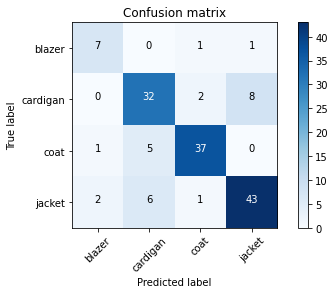

==================================================Q2 result==================================================
when optimizer = Adam, learning rate = 1e-05, weight decay = 0, overall testing accuracy = 0.808
label = blazer, per class accuracy = 0.5555555555555556
label = cardigan, per class accuracy = 0.7142857142857143
label = coat, per class accuracy = 0.8372093023255814
label = jacket, per class accuracy = 0.9038461538461539


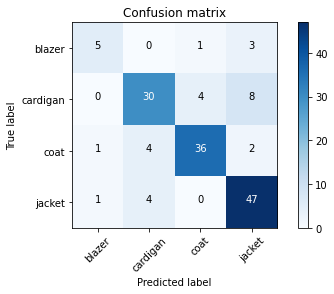

==================================================Q2 result==================================================
when optimizer = SGD, learning rate = 0.005, weight decay = 0, overall testing accuracy = 0.788
label = blazer, per class accuracy = 0.6666666666666666
label = cardigan, per class accuracy = 0.7142857142857143
label = coat, per class accuracy = 0.8372093023255814
label = jacket, per class accuracy = 0.8269230769230769


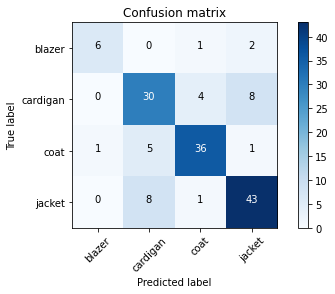

==================================================Q2 result==================================================
when optimizer = SGD, learning rate = 0.001, weight decay = 0, overall testing accuracy = 0.801
label = blazer, per class accuracy = 0.7777777777777778
label = cardigan, per class accuracy = 0.7142857142857143
label = coat, per class accuracy = 0.8837209302325582
label = jacket, per class accuracy = 0.8076923076923077


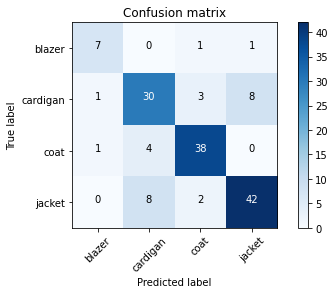

In [60]:
#Q2 Adam
#learning rate = 0.00001, weight decay = 0.1 (&weight decay = 0.0)
print_result("Q2", "Adam", 0.00001, 0.1)
print_result("Q2", "Adam", 0.00001, 0)
#Q2 SGD
#learning rate = 0.005, weight_decay = 0.0 & lr = 0.001, weight decay = 0.
print_result("Q2", "SGD", 0.005, 0)
print_result("Q2", "SGD", 0.001, 0)

從上圖可以觀察到，結果大約與預測結果相符，但仍有三個模型coat的準確率大於jacket。
可能的原因如下：
1. dropout layer在訓練過程中，恰巧dropout到一些偏好jacket label的neuron，所以導致此結果。
2. coat照片的色彩或對比比較鮮明，轉成tensor之後每個feature的variance較大，所以導致coat這個label的學習效果比較好。

## Q3

### Tuning, Optimizer = Adam

In [ ]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2]
min_valid_loss_list_Q3_Adam = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q3/Adam/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model(isFreeze = True)
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q3_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q3_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list_Q3_Adam.append(Q3_tune_model.best_valid_loss)

Start training model: learning rate = 0.0005, weight decay = 0
Epoch 1: 204.005 seconds elapsed in epoch.
Epoch 1: training loss = 1.323 (accuracy: 36.695%), validation loss = 1.297 (accuracy: 38.095%)
Epoch 2: 16.268 seconds elapsed in epoch.
Epoch 2: training loss = 1.232 (accuracy: 44.188%), validation loss = 1.179 (accuracy: 46.667%)
Epoch 3: 16.312 seconds elapsed in epoch.
Epoch 3: training loss = 1.189 (accuracy: 46.013%), validation loss = 1.158 (accuracy: 48.571%)
Epoch 4: 16.204 seconds elapsed in epoch.
Epoch 4: training loss = 1.171 (accuracy: 46.494%), validation loss = 1.133 (accuracy: 49.524%)
Epoch 5: 16.250 seconds elapsed in epoch.
Epoch 5: training loss = 1.151 (accuracy: 49.664%), validation loss = 1.123 (accuracy: 50.476%)
Epoch 6: 16.240 seconds elapsed in epoch.
Epoch 6: training loss = 1.126 (accuracy: 49.856%), validation loss = 1.085 (accuracy: 51.429%)
Epoch 7: 16.423 seconds elapsed in epoch.
Epoch 7: training loss = 1.097 (accuracy: 51.585%), validation los

In [ ]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2]
df = pd.DataFrame(index = weight_list)
count = 0
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list_Q3_Adam[count])
        count +=1 
    df[lr] = temp
index = np.unravel_index(np.argmin(df, axis=None), df.shape)
row_index = index[0]
column_index = index[1]
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with Adam optimizer : learning rate = {}, weight decay = {}".format(lr_list[column_index], weight_list[row_index]))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with Adam optimizer : learning rate = 0.0001, weight decay = 0
      0.00050   0.00010   0.00005   0.00001
0.0  0.942281  0.919803  0.954571  0.938884
0.1  1.093395  1.001242  0.977782  1.011718
0.2  1.202506  1.104850  1.089413  1.085146


### Tuning, SGD

In [ ]:
lr_list = [0.01, 0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2]
min_valid_loss_list_Q3_SGD = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q3/SGD/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model(isFreeze = True)
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q3_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q3_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list_Q3_SGD.append(Q3_tune_model.best_valid_loss)

Start training model: learning rate = 0.01, weight decay = 0
Epoch 1: 593.686 seconds elapsed in epoch.
Epoch 1: training loss = 1.300 (accuracy: 37.176%), validation loss = 1.281 (accuracy: 33.333%)
Epoch 2: 22.351 seconds elapsed in epoch.
Epoch 2: training loss = 1.275 (accuracy: 40.346%), validation loss = 1.268 (accuracy: 33.333%)
Epoch 3: 22.346 seconds elapsed in epoch.
Epoch 3: training loss = 1.237 (accuracy: 42.459%), validation loss = 1.258 (accuracy: 33.333%)
Epoch 4: 22.328 seconds elapsed in epoch.
Epoch 4: training loss = 1.228 (accuracy: 43.132%), validation loss = 1.206 (accuracy: 38.095%)
Epoch 5: 22.449 seconds elapsed in epoch.
Epoch 5: training loss = 1.219 (accuracy: 45.629%), validation loss = 1.189 (accuracy: 41.905%)
Epoch 6: 22.691 seconds elapsed in epoch.
Epoch 6: training loss = 1.183 (accuracy: 45.821%), validation loss = 1.163 (accuracy: 44.762%)
Epoch 7: 22.413 seconds elapsed in epoch.
Epoch 7: training loss = 1.182 (accuracy: 47.743%), validation loss 

In [3]:
lr_list = [0.01, 0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2]
df = pd.DataFrame(index = weight_list)
count = 0
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list_Q3_SGD[count])
        count +=1 
    df[lr] = temp
index = np.unravel_index(np.argmin(df, axis=None), df.shape)
row_index = index[0]
column_index = index[1]
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with SGD optimizer : learning rate = {}, weight decay = {}".format(lr_list[column_index], weight_list[row_index]))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with SGD optimizer : learning rate = 0.005, weight decay = 0
       0.0100    0.0050    0.0010    0.0005
0.0  0.953703  0.927372  0.973856  1.100165
0.1  0.981783  0.984598  0.977782  1.121718
0.2  1.085904  1.079832  1.089413  1.145146


## Q3 Testing

==================================================Q3 result==================================================
when optimizer = Adam, learning rate = 0.0001, weight decay = 0, overall testing accuracy = 0.596
label = blazer, per class accuracy = 0.4444444444444444
label = cardigan, per class accuracy = 0.6666666666666666
label = coat, per class accuracy = 0.5116279069767442
label = jacket, per class accuracy = 0.6346153846153846


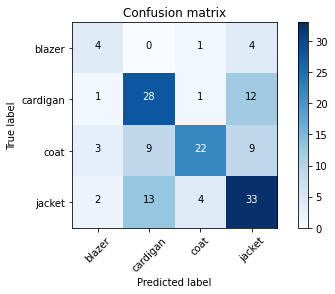

==================================================Q3 result==================================================
when optimizer = Adam, learning rate = 1e-05, weight decay = 0, overall testing accuracy = 0.596
label = blazer, per class accuracy = 0.3333333333333333
label = cardigan, per class accuracy = 0.5238095238095238
label = coat, per class accuracy = 0.5581395348837209
label = jacket, per class accuracy = 0.7307692307692307


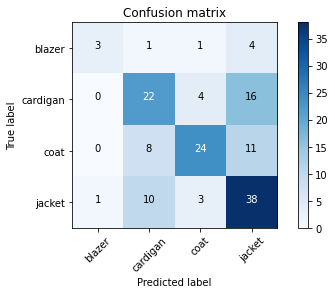

==================================================Q3 result==================================================
when optimizer = SGD, learning rate = 0.01, weight decay = 0.1, overall testing accuracy = 0.610
label = blazer, per class accuracy = 0.0
label = cardigan, per class accuracy = 0.7142857142857143
label = coat, per class accuracy = 0.5581395348837209
label = jacket, per class accuracy = 0.6730769230769231


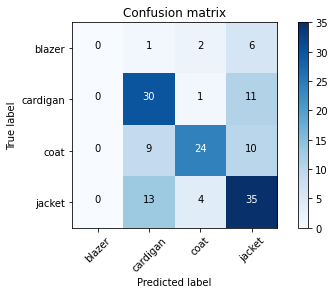

==================================================Q3 result==================================================
when optimizer = SGD, learning rate = 0.005, weight decay = 0, overall testing accuracy = 0.651
label = blazer, per class accuracy = 0.3333333333333333
label = cardigan, per class accuracy = 0.7142857142857143
label = coat, per class accuracy = 0.5581395348837209
label = jacket, per class accuracy = 0.7307692307692307


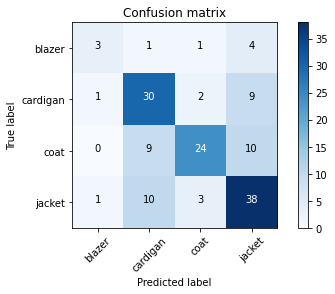

In [17]:
#Q3 Adam
#lr = 0.0001, w = 0.0, lr = 0.00001, w = 0.0
print_result("Q3", "Adam", 0.0001, 0)
print_result("Q3", "Adam", 0.00001, 0)
#Q3 SGD
#lr = 0.01, w = 0.1, lr = 0.005, w = 0
print_result("Q3", "SGD", 0.01, 0.1)
print_result("Q3", "SGD", 0.005, 0)

## Q4

### Tuning, Optimizer = Adam

In [6]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2]
min_valid_loss_list_Q4_Adam = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q4/Adam/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model(isFreeze = False, isPretrained = False)
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q4_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q4_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list_Q4_Adam.append(Q4_tune_model.best_valid_loss)

Start training model: learning rate = 0.0005, weight decay = 0
Epoch 1: 600.380 seconds elapsed in epoch.
Epoch 1: training loss = 1.388 (accuracy: 35.639%), validation loss = 1.296 (accuracy: 33.333%)
Epoch 2: 17.387 seconds elapsed in epoch.
Epoch 2: training loss = 1.311 (accuracy: 37.272%), validation loss = 1.493 (accuracy: 30.476%)
Epoch 3: 17.035 seconds elapsed in epoch.
Epoch 3: training loss = 1.297 (accuracy: 39.385%), validation loss = 1.291 (accuracy: 32.381%)
Epoch 4: 17.099 seconds elapsed in epoch.
Epoch 4: training loss = 1.274 (accuracy: 39.962%), validation loss = 1.289 (accuracy: 36.190%)
Epoch 5: 17.228 seconds elapsed in epoch.
Epoch 5: training loss = 1.276 (accuracy: 36.503%), validation loss = 1.296 (accuracy: 43.810%)
Epoch 6: 17.072 seconds elapsed in epoch.
Epoch 6: training loss = 1.265 (accuracy: 39.097%), validation loss = 1.236 (accuracy: 40.000%)
Epoch 7: 17.136 seconds elapsed in epoch.
Epoch 7: training loss = 1.267 (accuracy: 40.250%), validation los

In [7]:
lr_list = [0.0005, 0.0001, 0.00005, 0.00001]
weight_list = [0, 0.1, 0.2]
df = pd.DataFrame(index = weight_list)
count = 0
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list_Q4_Adam[count])
        count +=1 
    df[lr] = temp
index = np.unravel_index(np.argmin(df, axis=None), df.shape)
row_index = index[0]
column_index = index[1]
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with Adam optimizer : learning rate = {}, weight decay = {}".format(lr_list[column_index], weight_list[row_index]))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with Adam optimizer : learning rate = 0.0001, weight decay = 0
      0.00050   0.00010   0.00005   0.00001
0.0  1.216843  1.132760  1.187949  1.170015
0.1  1.266557  1.220878  1.163302  1.165067
0.2  1.289217  1.233405  1.217743  1.294130


### Tuning, Optimizer =  SGD

In [9]:
lr_list = [0.01, 0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2]
min_valid_loss_list_Q4_SGD = []
train_on_gpu = torch.cuda.is_available()
for lr in lr_list:
    for weight in weight_list:
        save_file_name = "/content/gdrive/My Drive/SLDL/hw5/Q4/SGD/resnet50_lr_" + str(lr) + "_weight_" + str(weight) + ".pt"
        model = reset_model(isFreeze = False, isPretrained = False)
        if train_on_gpu:
            model = model.to('cuda')
        optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight)
        nepoch = 200
        Q4_tune_model = Resnet50()
        print("Start training model: learning rate = {}, weight decay = {}".format(lr, weight))
        model_finish = Q4_tune_model.train(train_on_gpu, model, nepoch, optimizer, save_file_name, dataloaders['train'], dataloaders['val'], verbose = True)
        min_valid_loss_list_Q4_SGD.append(Q4_tune_model.best_valid_loss)

Start training model: learning rate = 0.01, weight decay = 0
Epoch 1: 16.895 seconds elapsed in epoch.
Epoch 1: training loss = 1.325 (accuracy: 35.447%), validation loss = 1.301 (accuracy: 33.333%)
Epoch 2: 16.983 seconds elapsed in epoch.
Epoch 2: training loss = 1.301 (accuracy: 36.023%), validation loss = 1.334 (accuracy: 33.333%)
Epoch 3: 16.938 seconds elapsed in epoch.
Epoch 3: training loss = 1.286 (accuracy: 39.001%), validation loss = 1.336 (accuracy: 35.238%)
Epoch 4: 17.106 seconds elapsed in epoch.
Epoch 4: training loss = 1.291 (accuracy: 38.329%), validation loss = 1.312 (accuracy: 33.333%)
Epoch 5: 17.146 seconds elapsed in epoch.
Epoch 5: training loss = 1.291 (accuracy: 39.097%), validation loss = 1.323 (accuracy: 33.333%)
Epoch 6: 16.959 seconds elapsed in epoch.
Epoch 6: training loss = 1.288 (accuracy: 38.713%), validation loss = 1.288 (accuracy: 33.333%)
Epoch 7: 17.057 seconds elapsed in epoch.
Epoch 7: training loss = 1.284 (accuracy: 39.001%), validation loss =

In [10]:
lr_list = [0.01, 0.005, 0.001, 0.0005]
weight_list = [0, 0.1, 0.2]
df = pd.DataFrame(index = weight_list)
count = 0
for lr in lr_list:
    temp = []
    for weight in weight_list:
        temp.append(min_valid_loss_list_Q4_SGD[count])
        count +=1 
    df[lr] = temp
index = np.unravel_index(np.argmin(df, axis=None), df.shape)
row_index = index[0]
column_index = index[1]
print("x-axis: learning rate")
print("y-axis: weight decay")
print("Best hyperparameters with SGD optimizer : learning rate = {}, weight decay = {}".format(lr_list[column_index], weight_list[row_index]))
print(df)

x-axis: learning rate
y-axis: weight decay
Best hyperparameters with SGD optimizer : learning rate = 0.01, weight decay = 0
       0.0100    0.0050    0.0010    0.0005
0.0  1.244184  1.290267  1.280691  1.294435
0.1  1.289611  1.276932  1.283608  1.292377
0.2  1.299241  1.296731  1.293136  1.296046


## Q4 Testing

==================================================Q4 result==================================================
when optimizer = Adam, learning rate = 0.0001, weight decay = 0, overall testing accuracy = 0.459
label = blazer, per class accuracy = 0.0
label = cardigan, per class accuracy = 0.5238095238095238
label = coat, per class accuracy = 0.3023255813953488
label = jacket, per class accuracy = 0.6153846153846154


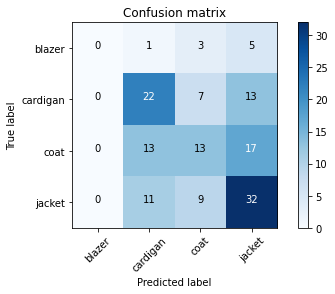

==================================================Q4 result==================================================
when optimizer = Adam, learning rate = 5e-05, weight decay = 0.1, overall testing accuracy = 0.438
label = blazer, per class accuracy = 0.0
label = cardigan, per class accuracy = 0.4523809523809524
label = coat, per class accuracy = 0.23255813953488372
label = jacket, per class accuracy = 0.6730769230769231


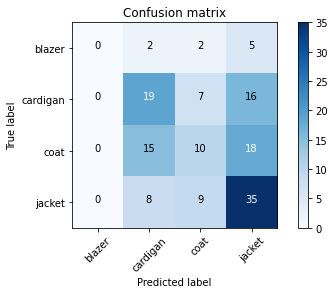

==================================================Q4 result==================================================
when optimizer = SGD, learning rate = 0.01, weight decay = 0, overall testing accuracy = 0.390
label = blazer, per class accuracy = 0.0
label = cardigan, per class accuracy = 0.5476190476190477
label = coat, per class accuracy = 0.0
label = jacket, per class accuracy = 0.6538461538461539


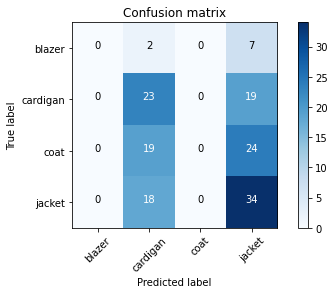

==================================================Q4 result==================================================
when optimizer = SGD, learning rate = 0.001, weight decay = 0, overall testing accuracy = 0.356
label = blazer, per class accuracy = 0.0
label = cardigan, per class accuracy = 0.0
label = coat, per class accuracy = 0.0
label = jacket, per class accuracy = 1.0


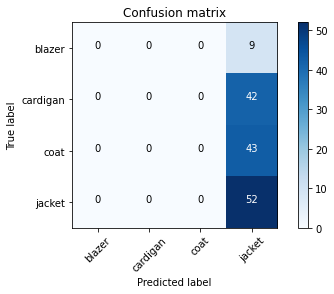

In [62]:
#Q4 Adam
#lr = 0.0001, w = 0, lr = 0.00005, w = 0.1
print_result("Q4", "Adam", 0.0001, 0)
print_result("Q4", "Adam", 0.00005, 0.1)
#Q4 SGD
#lr = 0.01, w = 0, lr = 0.001. w = 0
print_result("Q4", "SGD", 0.01, 0)
print_result("Q4", "SGD", 0.001, 0)

## 結論

從Q2到Q4的結果可以觀察出，預測能力最好的情形由大到小分別為
Pretrained Model + 訓練全部的Neuron -> Pretrained Model + 只訓練最後一層 -> 沒有經過Pretrained的Model。

觀察列點如下：
1. 有經過Pretrained的Model已經包含結果不錯的參數，所以想當然爾Testing的結果一定比較好。比較Q2及Q3的Model，有更新全部Layer的Model也一定比只訓練最後一層的Model還要好。

2. Adam Optimizer對此次任務普遍來說比SGD Optimizer表現得要好 (除了Q3的結果以外)

3. Jacket, coat, cardigan三個Label的預測準確度比較高，正如同一開始所猜想。